## Make Bratislava Blocks and graph


This notebook takes the Pokec graph data and processed metadata generated in **make_Pokec_Reduced_profiles.ipynb** as an input and outputs the lcc graph of nodes in the Bratislava region. We also output a coarse grained network consisting of 9 blocks made by differen combinations of the age and region name variables.

The graph data is origianlly directed, however, we take the edges to be undirected.

To do:
- Validate that we are getting the correct matrix from the number of connections.
- Code for the ordering of the matrix

Aim: Adapting the code from *pokec_make_Bratislava_blocks.py* to be in notebook form for greater clarity on the steps perfomed.

Created on 04/09/20

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import tqdm
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns

import Pokec_processing as PokProc

In [2]:
path_to_reduced_profiles = 'Data/reduced_pokec_profiles.csv'
all_profiles = pd.read_csv(path_to_reduced_profiles)
all_profiles.head()

,Unnamed: 0,user_id,gender,region,age,user_lat,user_lon
0,0,1,1.0,"zilinsky kraj, zilina",26.0,49.223467,18.739314
1,1,2,0.0,"zilinsky kraj, kysucke nove mesto",0.0,49.299918,18.786508
2,2,16,1.0,"zilinsky kraj, kysucke nove mesto",23.0,49.299918,18.786508
3,3,3,1.0,"bratislavsky kraj, bratislava - karlova ves",29.0,48.159240,17.052677
4,4,4,0.0,"banskobystricky kraj, brezno",26.0,48.805335,19.640961


## Filter missing values
Missing ages and locations are set to 0.0. Filter these out.

In [3]:
all_profiles = all_profiles.loc[(all_profiles['age'] > 0.0) & (all_profiles['user_lat'] > 0.0)]

Use the 0,25,50,75 and 100th percentiles of the distribution of ages.

## Set age and region bins

In [4]:
ages=list(all_profiles['age'])
age_ranges = [(np.percentile(ages, 0), np.percentile(ages, 25)-1), (np.percentile(ages, 25), np.percentile(ages, 50)-1)
    , (np.percentile(ages, 50), np.percentile(ages, 75)-1), (np.percentile(ages, 75), np.percentile(ages, 100))]
print("age ranges")
print(age_ranges)

region_names = ['bratislavsky kraj, bratislava - okolie','bratislavsky kraj, bratislava - petrzalka',
'bratislavsky kraj, bratislava - ruzinov']

age ranges
[(1.0, 17.0), (18.0, 21.0), (22.0, 28.0), (29.0, 112.0)]


In [5]:
bratislava_profiles = all_profiles.loc[all_profiles['region'].isin(region_names)]

#Shorter naming convention with caps
bratislava_profiles['region'] = [ k.split(' ')[-1].title() for k in list(bratislava_profiles['region']) ]

region_names = [ k.split(' ')[-1].title() for k in region_names ]

bratislava_profiles

<ipython-input-5-0cba52b5485a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bratislava_profiles['region'] = [ k.split(' ')[-1].title() for k in list(bratislava_profiles['region']) ]


,Unnamed: 0,user_id,gender,region,age,user_lat,user_lon
112,112,181,1.0,Ruzinov,26.0,48.149314,17.164505
314,314,344,0.0,Ruzinov,22.0,48.149314,17.164505
450,450,529,1.0,Okolie,22.0,48.295066,17.242634
804,804,834,1.0,Okolie,18.0,48.295066,17.242634
1247,1247,1138,0.0,Okolie,16.0,48.295066,17.242634
...,...,...,...,...,...,...,...
1632688,1632688,1632689,0.0,Petrzalka,31.0,48.110972,17.111290
1632720,1632720,1632721,1.0,Ruzinov,37.0,48.149314,17.164505
1632739,1632739,1632740,1.0,Okolie,26.0,48.295066,17.242634
1632753,1632753,1632754,1.0,Ruzinov,48.0,48.149314,17.164505


In [6]:
def age_range_string(age_ranges,index) :
    return f"ages_{int(age_ranges[index][0])}-{int(age_ranges[index][1])}"

def get_age_cat(age_ranges,age) :
    for group,age_range in enumerate(age_ranges) :
        if age_range[0] <= age <= age_range[1] :
            return age_range_string(age_ranges,group)

        
block_names = [ ]
block_ages = [ ]
for i in region_names :
    for j in range(len(age_ranges)) :
        block_names.append(i +'_'+ age_range_string(age_ranges,j) )
        block_ages.append(age_ranges[j])

bratislava_profiles['age_group'] = [get_age_cat(age_ranges,age) for age in list(bratislava_profiles['age'])]
bratislava_profiles['block'] = [ i +'_'+ j for i,j in zip(list(bratislava_profiles['region']),list(bratislava_profiles['age_group']))]
bratislava_profiles

<ipython-input-6-c1fde0c31d59>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bratislava_profiles['age_group'] = [get_age_cat(age_ranges,age) for age in list(bratislava_profiles['age'])]
<ipython-input-6-c1fde0c31d59>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bratislava_profiles['block'] = [ i +'_'+ j for i,j in zip(list(bratislava_profiles['region']),list(bratislava_profiles['age_group']))]


,Unnamed: 0,user_id,gender,region,age,user_lat,user_lon,age_group,block
112,112,181,1.0,Ruzinov,26.0,48.149314,17.164505,ages_22-28,Ruzinov_ages_22-28
314,314,344,0.0,Ruzinov,22.0,48.149314,17.164505,ages_22-28,Ruzinov_ages_22-28
450,450,529,1.0,Okolie,22.0,48.295066,17.242634,ages_22-28,Okolie_ages_22-28
804,804,834,1.0,Okolie,18.0,48.295066,17.242634,ages_18-21,Okolie_ages_18-21
1247,1247,1138,0.0,Okolie,16.0,48.295066,17.242634,ages_1-17,Okolie_ages_1-17
...,...,...,...,...,...,...,...,...,...
1632688,1632688,1632689,0.0,Petrzalka,31.0,48.110972,17.111290,ages_29-112,Petrzalka_ages_29-112
1632720,1632720,1632721,1.0,Ruzinov,37.0,48.149314,17.164505,ages_29-112,Ruzinov_ages_29-112
1632739,1632739,1632740,1.0,Okolie,26.0,48.295066,17.242634,ages_22-28,Okolie_ages_22-28
1632753,1632753,1632754,1.0,Ruzinov,48.0,48.149314,17.164505,ages_29-112,Ruzinov_ages_29-112


In [7]:
bratislava_user_ids = list(bratislava_profiles['user_id'])
print(len(bratislava_user_ids))

46106


## Read edge data

In [8]:
def read_edge_list(path_to_edge_list) :
    print("Reading edge data...")
    edge_data = pd.read_csv(path_to_edge_list,sep='\t',names=['id_1','id_2'],dtype=np.int32)
    return edge_data

In [9]:
path_to_edge_list = 'Data/raw_data/soc-pokec-relationships.txt'

edge_data = read_edge_list(path_to_edge_list)
edge_data.head()

Reading edge data...


,id_1,id_2
0,1,13
1,1,11
2,1,6
3,1,3
4,1,4


In [10]:
len(edge_data)

30622564

In [11]:
bratislava_edge_data = edge_data.loc[ (edge_data['id_1'].isin(bratislava_user_ids)) & (edge_data['id_2'].isin(bratislava_user_ids))]
print(len(bratislava_edge_data))

91482


## Build graph and extract LCC

In [12]:
graph = PokProc.make_graph_from_edge_data(bratislava_profiles,bratislava_edge_data,add_disconnected_nodes=False)
len(graph)

30953

In [13]:
Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
lcc_graph = graph.subgraph(Gcc[0])
print(len(lcc_graph))

29582


In [14]:
bratislava_lcc_profiles = bratislava_profiles.loc[bratislava_profiles['user_id'].isin(lcc_graph.nodes())]
len(bratislava_lcc_profiles)

29582

In [15]:
bratislava_lcc_profiles.to_csv("Data/bratislava_profiles.csv")

In [16]:
nx.write_graphml(lcc_graph,"Data/Bratislava_graph.graphml")

## Extract Block information

In [17]:
groups = [ bratislava_lcc_profiles.loc[bratislava_lcc_profiles['block']==block] for block in block_names]
groups_node_ids = [list(k['user_id']) for k in groups]
block_sizes = [len(k) for k in groups]

node_to_group_map = { i:j for i,j in zip(list(bratislava_lcc_profiles['user_id']),list(bratislava_lcc_profiles['block']))} # will this keep the correct order to map? 

for i,j in zip(block_names,block_sizes) :
    print(i,j)

Okolie_ages_1-17 1234
Okolie_ages_18-21 1939
Okolie_ages_22-28 3154
Okolie_ages_29-112 3458
Petrzalka_ages_1-17 1398
Petrzalka_ages_18-21 2106
Petrzalka_ages_22-28 5234
Petrzalka_ages_29-112 4550
Ruzinov_ages_1-17 586
Ruzinov_ages_18-21 1123
Ruzinov_ages_22-28 2444
Ruzinov_ages_29-112 2356


In [18]:
assert np.sum(block_sizes) == len(lcc_graph)

In [19]:
block_info = pd.DataFrame({'block_name':block_names,'block_size':block_sizes,'average_age':[np.mean(k) for k in block_ages]})
block_info

,block_name,block_size,average_age
0,Okolie_ages_1-17,1234,9.0
1,Okolie_ages_18-21,1939,19.5
2,Okolie_ages_22-28,3154,25.0
3,Okolie_ages_29-112,3458,70.5
4,Petrzalka_ages_1-17,1398,9.0
5,Petrzalka_ages_18-21,2106,19.5
6,Petrzalka_ages_22-28,5234,25.0
7,Petrzalka_ages_29-112,4550,70.5
8,Ruzinov_ages_1-17,586,9.0
9,Ruzinov_ages_18-21,1123,19.5


In [20]:
block_info.to_csv("Data/block_info.csv")

## Count edges between blocks + make connection prob matrix

In [21]:
# could make the interaction dataframe at this stage?

edge_counts = np.zeros((len(groups_node_ids),len(groups_node_ids)))
i=0
for group_1 in tqdm.tqdm_notebook(groups_node_ids) :
    for j,group_2 in enumerate(groups_node_ids) :
        num_edges_between = len([ k for k in nx.edge_boundary(lcc_graph,group_1,nbunch2=group_2) ])
        edge_counts[i][j]=num_edges_between
    i+=1

<ipython-input-21-402d670d1496>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for group_1 in tqdm.tqdm_notebook(groups_node_ids) :


  0%|          | 0/12 [00:00<?, ?it/s]

In [22]:
def check_symmetric(X : np.ndarray) :
    np.testing.assert_array_equal( X - X.T , np.zeros((X.shape[0],X.shape[1])) )
check_symmetric(edge_counts)

In [23]:
def prob_mat_from_edge_counts(block_sizes :  list , edge_counts : np.ndarray) :

    prob_mat = np.zeros(edge_counts.shape)
    
    for i in range(edge_counts.shape[0]) :
        for j in range(edge_counts.shape[1]) : 
            
            if i == j :
                prob_mat[i][j] = (2.0/(block_sizes[i]*(block_sizes[i]-1.0)))*edge_counts[i,j]
            else :
                prob_mat[i][j] = (1.0/(block_sizes[i]*block_sizes[j]))*edge_counts[i,j]
                
    return prob_mat

In [24]:
prob_mat = prob_mat_from_edge_counts(block_sizes,edge_counts)
prob_mat[:4,:4]

array([[1.37888246e-03, 3.60258550e-04, 5.39563355e-05, 2.62468914e-05],
       [3.60258550e-04, 9.26078203e-04, 2.49852590e-04, 5.47347661e-05],
       [5.39563355e-05, 2.49852590e-04, 4.27369250e-04, 1.25246045e-04],
       [2.62468914e-05, 5.47347661e-05, 1.25246045e-04, 2.59153480e-04]])

In [25]:
coupling_mat = np.dot( prob_mat , np.diag(block_sizes ) )
print(coupling_mat[:4,:4])

[[1.70154096 0.69854133 0.17017828 0.09076175]
 [0.44455905 1.79566563 0.78803507 0.18927282]
 [0.06658212 0.48446417 1.34792261 0.43310082]
 [0.03238866 0.10613071 0.39502603 0.89615273]]


In [26]:
coupling_graph = nx.from_numpy_matrix(coupling_mat)

In [27]:
nx.write_graphml(coupling_graph,"Data/Bratislava_coupling.graphml")

## Plotting of the coupling matrix (TBC - use this rather than dedicated script?!)

In [28]:
block_names_with_newline = [ k.split('_')[0] + '\n' + k.split('_')[2]  for k in block_names]

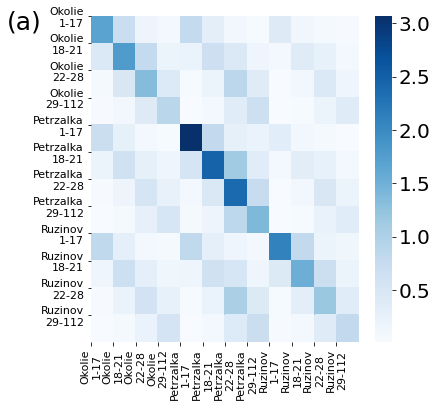

In [29]:
fig,ax = plt.subplots(figsize=(6,6))
#plt.imshow(coupling_mat,cmap='plasma')

hm = sns.heatmap(coupling_mat,cmap='Blues')

plt.yticks(np.arange(0,len(block_names),1))
ax.set_yticklabels(block_names_with_newline, rotation=0,fontsize=11)
plt.xticks(np.arange(0,len(block_names),1))
ax.set_xticklabels(block_names_with_newline, rotation=90,fontsize=11)

cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)

plt.text(-3.75,0.5,'(a)',fontsize=25)

#cbar = plt.colorbar()
plt.savefig("Plots/block_interactions.pdf",bbox_inches='tight')

## Check how to recover the symmetric probability matrix (

## Note - now that we know block level approx gives reasonable approx for magnetisation. This suggests that we have the correct

$ \kappa = \Omega \mathcal{N} $

-->

$ \Omega =  \kappa \mathcal{N}^{-1} $

The order of opperations does matter here

In [30]:
N_mat = np.diag(block_sizes)
#np.dot( prob_mat, N_mat)
prob_mat = np.dot(   coupling_mat, np.linalg.inv(N_mat) )
print(prob_mat[:4,:4])

[[1.37888246e-03 3.60258550e-04 5.39563355e-05 2.62468914e-05]
 [3.60258550e-04 9.26078203e-04 2.49852590e-04 5.47347661e-05]
 [5.39563355e-05 2.49852590e-04 4.27369250e-04 1.25246045e-04]
 [2.62468914e-05 5.47347661e-05 1.25246045e-04 2.59153480e-04]]


In [31]:
# For testing only - this saved version was produced using the previous version of the code.
coupling_graph = nx.read_graphml('Data/Bratislava_coupling.graphml')
nx.to_numpy_matrix(coupling_graph)

matrix([[1.70154096, 0.44455905, 0.06658212, 0.03238866, 0.70386266,
         0.18376068, 0.02674818, 0.01120879, 0.82935154, 0.1460374 ,
         0.03191489, 0.01273345],
        [0.44455905, 1.79566563, 0.48446417, 0.10613071, 0.27896996,
         0.62060779, 0.16488345, 0.06637363, 0.29351536, 0.66429207,
         0.20335516, 0.06706282],
        [0.06658212, 0.48446417, 1.34792261, 0.39502603, 0.08082976,
         0.27730294, 0.52541078, 0.26373626, 0.07679181, 0.2983081 ,
         0.57201309, 0.21943973],
        [0.03238866, 0.10613071, 0.39502603, 0.89615273, 0.04291845,
         0.14387464, 0.2369125 , 0.50153846, 0.05972696, 0.13891362,
         0.25654664, 0.55517827],
        [0.70386266, 0.27896996, 0.08082976, 0.04291845, 3.0694345 ,
         0.53703704, 0.07298433, 0.06197802, 0.82593857, 0.14425646,
         0.03764321, 0.01188455],
        [0.18376068, 0.62060779, 0.27730294, 0.14387464, 0.53703704,
         2.46270784, 0.45319068, 0.16549451, 0.29351536, 0.62956367,
  

### Task: confirm we use Kappa vs the Transpose - note the fact that block level approximation works is some evidence.

Expect that the smaller block will have more outgoing connections on average - i.e. to have the same number of edges increases the mean degree more. 

Looks like the current version may indeed be correct.

In [32]:
coupling_mat[:3,:3]

array([[1.70154096, 0.69854133, 0.17017828],
       [0.44455905, 1.79566563, 0.78803507],
       [0.06658212, 0.48446417, 1.34792261]])

In [33]:
edge_counts[:3,:3]

array([[1049.,  862.,  210.],
       [ 862., 1740., 1528.],
       [ 210., 1528., 2125.]])

In [34]:
block_sizes[:3]

[1234, 1939, 3154]

In [35]:
kappa_12 = (block_sizes[0]/block_sizes[1])*coupling_mat[0,1]
print(kappa_12)

0.44455905105724597
